In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.sans-serif'] = 'SimHei'  # 常用的中文字体，SimHei是黑体
rcParams['axes.unicode_minus'] = False  # 解决负号显示为乱码的问题

# 考虑到分红拆股等影响，以及前复权数据可能引入未来信息，尽量使用后复权数据

# 输入的dataframe需要包含date、close、open
## date应该是datetime格式，否则画图会有问题，回测系统会自动转换格式并对日期进行排序。


In [5]:
df=pd.read_csv("backtest/000001.csv")
df=df.rename(columns={'trade_date':'date','ts_code':'code'})
df.date=pd.to_datetime(df.date,format='%Y%m%d')

In [6]:
data=df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   code       2894 non-null   object        
 1   date       2894 non-null   datetime64[ns]
 2   open       2894 non-null   float64       
 3   high       2894 non-null   float64       
 4   low        2894 non-null   float64       
 5   close      2894 non-null   float64       
 6   pre_close  2894 non-null   float64       
 7   change     2894 non-null   float64       
 8   pct_chg    2894 non-null   float64       
 9   vol        2894 non-null   float64       
 10  amount     2894 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 248.8+ KB


In [7]:
data.head()

,code,date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,2024-12-05,11.44,11.50,11.41,11.44,11.46,-0.02,-0.1745,687108.83,786137.964
1,000001.SZ,2024-12-04,11.44,11.53,11.37,11.46,11.49,-0.03,-0.2611,1007470.59,1154623.370
2,000001.SZ,2024-12-03,11.37,11.50,11.35,11.49,11.39,0.10,0.8780,1082559.36,1236992.678
3,000001.SZ,2024-12-02,11.39,11.40,11.31,11.39,11.38,0.01,0.0879,975433.66,1108785.597
4,000001.SZ,2024-11-29,11.37,11.46,11.34,11.38,11.34,0.04,0.3527,1028487.58,1173316.154


# 策略使用收盘价计算并只给出日期和买卖方向

In [9]:
class MovingAverageStrategy:
    def __init__(self, short_window=12, long_window=26):
        self.short_window = short_window
        self.long_window = long_window
        self.name = f'MovingAverage ({self.short_window},{self.long_window})'
        
    def generate_signals(self, data):
        data = data.copy()
        data['ma_short'] = data['close'].rolling(window=self.short_window).mean()
        data['ma_long'] = data['close'].rolling(window=self.long_window).mean()

        # 生成买入信号：短期均线向上突破长期均线
        data['signal'] = 0
        data['signal'] = np.where((data['ma_short'] > data['ma_long']) & (data['ma_short'].shift(1) <= data['ma_long'].shift(1)), 1, data['signal'])

        # 生成卖出信号：价格跌破长期均线
        data['signal'] = np.where((data['close'] < data['ma_long']) & (data['close'].shift(1) >= data['ma_long'].shift(1)), -1, data['signal'])

        # 去除连续相同信号，只保留第一次出现的信号
        #data['signal'] = np.where(data['signal'] != data['signal'].shift(), data['signal'], 0)
        return data[['date', 'signal']]
        #return data


# 采用收盘价给出买卖信号，成交价格采用第二天开盘价


In [11]:

class BacktestSystem:
    def __init__(self, data, strategy,start_date='2023-01-01',end_date='2023-12-31', initial_balance=1000000, transaction_fee=0.000, slippage=0.0001):
        '''
        data 是一个包含历史交易数据的 DataFrame，包括日期、开盘价、收盘价等信息。

        strategy 是一个策略对象，它包含了生成交易信号的方法，比如 generate_signals。

        `start_date` 和 `end_date` 是回测的时间范围，这里设置为 '2023-01-01' 到 '2023-12-31'，表示只使用2023年的数据进行回测。

        `initial_balance` 是回测开始时的初始资金，这里是1000000，代表一百万元。
    
        `transaction_fee` 是交易手续费的比例，这里是0.00，也就是没有手续费。

        `slippage` 是滑点的比例，这里是0.0001，也就是万分之一。
        '''
        # 检查并处理输入的 DataFrame
        if 'date' not in data.columns:
            raise ValueError("Input DataFrame must contain a 'date' column.")
        data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        # 删除重复的日期
        data = data.drop_duplicates(subset='date')
        
        # 按照日期排序
        data = data.sort_values(by='date')
        self.original_data = data.copy()
        self.strategy = strategy
        self.strategy_name = strategy.name
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.slippage = slippage
        self.results = []
        self.trade_log = pd.DataFrame()
        
    def run_backtest(self, size=1):
        signals = self.strategy.generate_signals(self.original_data)
        self.data = pd.merge(self.original_data, signals, on='date', how='left')
        self.data['signal'] = self.data['signal'].fillna(0)
        
        # 生成下一天的开盘价
        self.data['next_open'] = self.data['open'].shift(-1)
        self.data['next_open'] = self.data['next_open'].fillna(self.data['close'])

        balance = self.initial_balance
        position = 0
        if self.data.empty:
            raise ValueError("Merged DataFrame is empty. Please check your input data and strategy.")
        trades = []
        last_date = self.data['date'].iloc[-1]

        for i, row in self.data.iterrows():
            signal = row['signal']
            price = row['next_open']  # 次日开盘价
            today_close = row['close']
            current_date = row['date']

            # 最后一天不交易
            if current_date == last_date and True:
                continue

            # 买卖限制逻辑
            can_buy = (price <= today_close * 1.099)
            can_sell = (price >= today_close * 0.901)

            # 计算当前总资产
            total_asset = balance + position * price

            if signal == 1 and can_buy:
                # 买入总资产的20%或最大现金
                buy_value = min( total_asset * size,balance)
                # 计算滑点和手续费后的买入价格
                buy_cost_per_share = price * (1 + self.slippage) * (1 + self.transaction_fee)
                # 能买到的股数（先不考虑100股整数限制）
                tentative_shares = int(buy_value // buy_cost_per_share)
                
                # 向下取整到100股整数倍
                buy_amount = (tentative_shares // 100) * 100

                if buy_amount > 0:
                    cost = buy_amount * price * (1 + self.slippage) * (1 + self.transaction_fee)
                    if cost <= balance:
                        fee = buy_amount * price * (1 + self.slippage) * self.transaction_fee
                        slip = buy_amount * price * self.slippage
                        traded_amount = buy_amount * price * (1 + self.slippage)

                        balance -= cost
                        position += buy_amount

                        trades.append({
                            'date': current_date,
                            'action': 'buy',
                            'price': price * (1 + self.slippage),
                            'amount': buy_amount,
                            'balance': balance,
                            'position': position,
                            'fee': fee,
                            'slippage': slip,
                            'traded_amount': traded_amount
                        })

            elif signal == -1 and position > 0 and can_sell:
                sell_value = min(total_asset * size,position*price)
                
                # 卖出当前总资产的20%，如果不足则全部持仓卖出
                
                if sell_value > 0:
                    sell_price = price * (1 - self.slippage)
                    sell_amount = (int(sell_value//sell_price ) // 100) * 100
                    base_revenue = sell_amount * sell_price
                    fee = base_revenue * self.transaction_fee
                    slip = sell_amount * price * self.slippage
                    revenue = base_revenue * (1 - self.transaction_fee)
                    
                    balance += revenue
                    position -= sell_amount

                    trades.append({
                        'date': current_date,
                        'action': 'sell',
                        'price': sell_price,
                        'amount': sell_amount,
                        'balance': balance,
                        'position': position,
                        'fee': fee,
                        'slippage': slip,
                        'traded_amount': base_revenue
                    })

            total_asset = balance + position * price
            self.results.append({
                'date': row['date'],
                'balance': balance,
                'position': position,
                'price': price,
                'total_asset': total_asset
            })

        # 最终结算
        final_price = self.data.iloc[-1]['close']
        total_asset = balance + position * final_price
        self.results.append({
            'date': self.data.iloc[-1]['date'],
            'balance': balance,
            'position': position,
            'price': final_price,
            'total_asset': total_asset
        })

        self.trade_log = pd.DataFrame(trades)
        self.results = pd.DataFrame(self.results)
        self.final_balance = total_asset

    def calculate_statistics(self):
        import math
        self.results['daily_return'] = self.results['total_asset'].pct_change().fillna(0)
        self.results['value'] = self.results['total_asset']/self.initial_balance

        total_days = len(self.results)
        first_trade_date = self.results.iloc[0]['date']
        last_trade_date = self.results.iloc[-1]['date']
        winning_days = (self.results['daily_return'] > 0).sum()
        losing_days = (self.results['daily_return'] < 0).sum()

        initial_capital = self.initial_balance
        final_capital = self.final_balance
        total_return = (final_capital - initial_capital) / initial_capital

        annualized_return = (1 + total_return) ** (250 / total_days) - 1 if total_days > 0 else 0

        rolling_max = self.results['total_asset'].cummax()
        drawdown = self.results['total_asset'] / rolling_max - 1
        max_drawdown = drawdown.min()
        max_drawdown_value = rolling_max.max() - rolling_max.max()*(1+max_drawdown)

        # 计算最长回撤天数
        dd_periods = 0
        max_dd_periods = 0
        for d in drawdown:
            if d < 0:
                dd_periods += 1
                if dd_periods > max_dd_periods:
                    max_dd_periods = dd_periods
            else:
                dd_periods = 0

        total_trades = len(self.trade_log)
        total_profit_loss = final_capital - initial_capital
        total_fee = self.trade_log['fee'].sum() if 'fee' in self.trade_log.columns else 0
        total_slippage = self.trade_log['slippage'].sum() if 'slippage' in self.trade_log.columns else 0
        total_traded_amount = self.trade_log['traded_amount'].sum() if 'traded_amount' in self.trade_log.columns else 0

        avg_daily_pnl = total_profit_loss / total_days if total_days > 0 else 0
        avg_daily_fee = total_fee / total_days if total_days > 0 else 0
        avg_daily_slippage = total_slippage / total_days if total_days > 0 else 0
        avg_daily_traded_amount = total_traded_amount / total_days if total_days > 0 else 0
        avg_daily_return = self.results['daily_return'].mean()
        return_std = self.results['daily_return'].std()
        sharpe_ratio = (avg_daily_return / return_std * np.sqrt(250)) if return_std != 0 else 0
        return_drawdown_ratio = total_return / abs(max_drawdown) if max_drawdown != 0 else math.inf

        benchmark_return = (self.data.iloc[-1]['close'] - self.data.iloc[0]['close']) / self.data.iloc[0]['close']

        print("首个交易日：", first_trade_date)
        print("最后交易日：", last_trade_date)
        print("总交易日：", total_days)
        print("盈利交易日：", winning_days)
        print("亏损交易日：", losing_days)
        print("起始资金：", initial_capital)
        print("结束资金：", final_capital)
        print("总收益率：{:.2%}".format(total_return))
        print("年化收益：{:.2%}".format(annualized_return))
        print("最大回撤：{:.2f}".format(max_drawdown_value))
        print("百分比最大回撤：{:.2%}".format(max_drawdown))
        print("最长回撤天数：", max_dd_periods)
        print("总盈亏：{:.2f}".format(total_profit_loss))
        print("总手续费：{:.2f}".format(total_fee))
        print("总滑点：{:.2f}".format(total_slippage))
        print("总成交金额：{:.2f}".format(total_traded_amount))
        print("总成交笔数：", total_trades)
        print("日均盈亏：{:.2f}".format(avg_daily_pnl))
        print("日均手续费：{:.2f}".format(avg_daily_fee))
        print("日均滑点：{:.2f}".format(avg_daily_slippage))
        print("日均成交金额：{:.2f}".format(avg_daily_traded_amount))
        print("日均收益率：{:.4f}".format(avg_daily_return))
        print("收益标准差：{:.4f}".format(return_std))
        print("Sharpe Ratio：{:.4f}".format(sharpe_ratio))
        print("收益回撤比：{:.4f}".format(return_drawdown_ratio))
        print("基准收益率：{:.2%}".format(benchmark_return))

        benchmark_value = self.data['close'] / self.data['close'].iloc[0]
        benchmark_return_line = benchmark_value*self.initial_balance

        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        plt.plot(self.results['date'], self.results['value'], label=f'{self.strategy_name} Value', color='b')
        plt.plot(self.results['date'], benchmark_value, label='Benchmark Value', color='orange')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.title(f'{self.strategy_name} Portfolio Value vs Benchmark Over Time')
        plt.legend()
        plt.show()

        excess_return=(self.results['total_asset'] - benchmark_return_line).fillna(0)/self.initial_balance
        plt.figure(figsize=(12, 6))
        plt.plot(self.results['date'], excess_return, label=f'{self.strategy_name} Cumulative Excess Return', color='g')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Excess Return')
        plt.title('Cumulative Excess Returns Over Time')
        plt.legend()
        plt.show()

    def plot_results(self):
        plt.figure(figsize=(18, 9))
        plt.plot(self.results['date'], self.results['total_asset'], label='Total Asset')

        if not self.trade_log.empty:
            buys = self.trade_log[self.trade_log['action'] == 'buy']
            sells = self.trade_log[self.trade_log['action'] == 'sell']
            plt.scatter(buys['date'], buys['price']+10000, marker='^', color='g', label='Buy', s=100)
            plt.scatter(sells['date'], sells['price']+10000, marker='v', color='r', label='Sell', s=100)

        plt.title('Backtest Results')
        plt.xlabel('Date')
        plt.ylabel('Total Asset')
        plt.legend()
        plt.grid(False)
        plt.show()

    def print_trade_log(self):
        print("Trade Log:")
        print(self.trade_log)

    def print_final_balance(self):
        print(f"Final Balance: {self.final_balance:.2f}")

    def get_final_results(self):
        if len(self.results) > 0:
            initial_capital = self.initial_balance
            final_capital = self.final_balance
            total_return = (final_capital - initial_capital) / initial_capital
            trade_log=self.trade_log
            trade_log=trade_log.to_dict(orient='records')
            return {
                'total_return': total_return,
                'final_capital': final_capital,
                
                'trade_log' : trade_log
            }
        else:
            return {
                'total_return': None,
                'final_capital': None
            }




In [12]:
if __name__ == "__main__":
    # 平安银行2023年1月1日~12月31日数据
    # data需包含至少['date','open','close']列
    data=df.copy()
    #data = data[(data['date'] >= '2023-01-01') & (data['date'] <= '2023-12-31')]
    
    # 下面是示例，在实际使用中请用真实数据替换
    strategy = MovingAverageStrategy(short_window=12, long_window=26)
    backtest = BacktestSystem(data, strategy, initial_balance=1000000, transaction_fee=0.00, slippage=0.0001)
    backtest.run_backtest(size=0.2)
    #backtest.calculate_statistics()
    # 如需可视化或日志可解注
    # backtest.plot_results()
    #backtest.print_trade_log()
    # backtest.print_final_balance()

In [13]:
backtest.get_final_results()

{'total_return': -0.003057387299999944,
 'final_capital': 996942.6127,
 'trade_log': [{'date': Timestamp('2023-05-15 00:00:00'),
   'action': 'buy',
   'price': 12.80128,
   'amount': 15600,
   'balance': 800300.032,
   'position': 15600,
   'fee': 0.0,
   'slippage': 19.968,
   'traded_amount': 199699.968},
  {'date': Timestamp('2023-05-16 00:00:00'),
   'action': 'sell',
   'price': 12.578742,
   'amount': 15600,
   'balance': 996528.4072,
   'position': 0,
   'fee': 0.0,
   'slippage': 19.6248,
   'traded_amount': 196228.3752},
  {'date': Timestamp('2023-07-25 00:00:00'),
   'action': 'buy',
   'price': 11.651165,
   'amount': 17100,
   'balance': 797293.4857000001,
   'position': 17100,
   'fee': 0.0,
   'slippage': 19.9215,
   'traded_amount': 199234.9215},
  {'date': Timestamp('2023-08-14 00:00:00'),
   'action': 'sell',
   'price': 11.688831,
   'amount': 17000,
   'balance': 996003.6127,
   'position': 100,
   'fee': 0.0,
   'slippage': 19.873,
   'traded_amount': 198710.127}]}

Final Balance: 996942.61


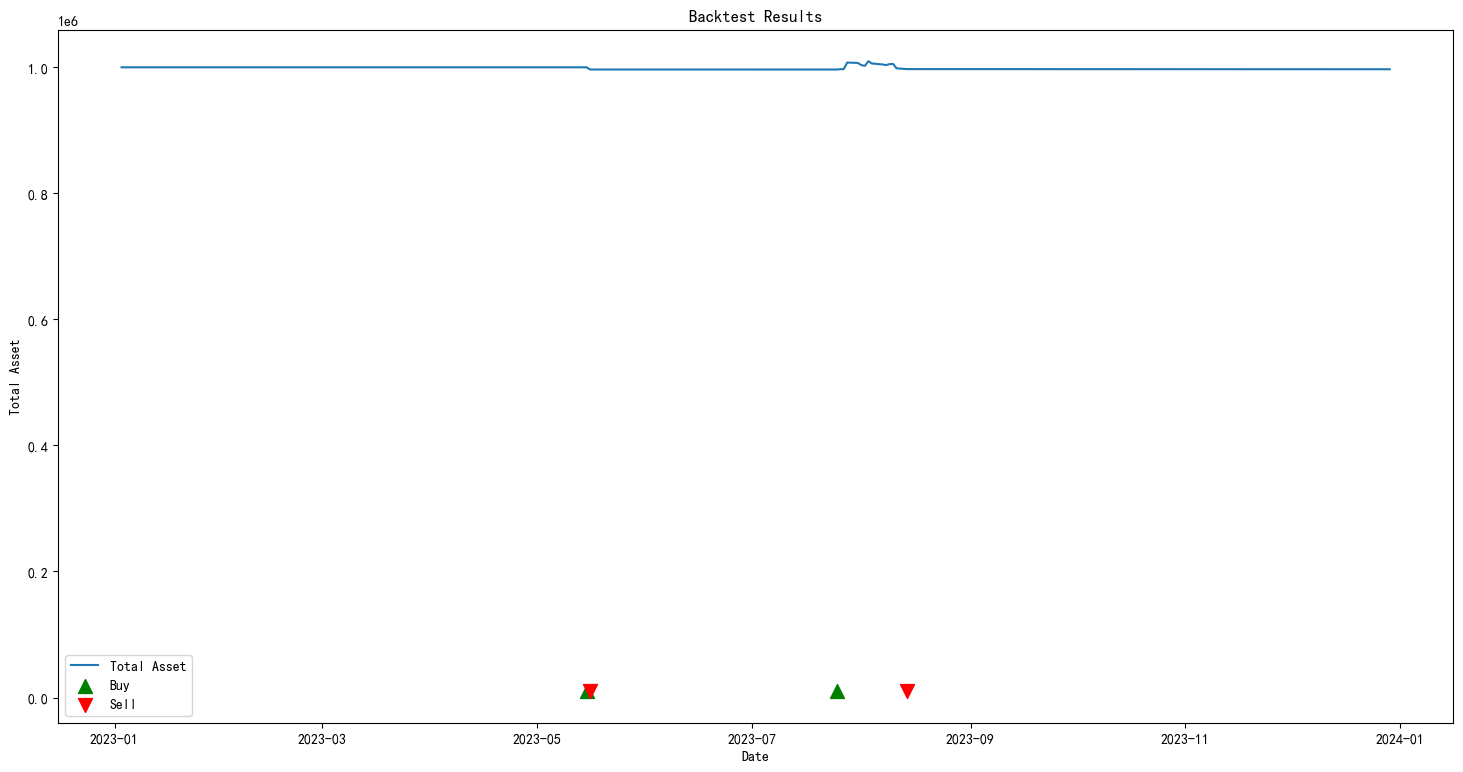

Trade Log:
        date action      price  amount      balance  position  fee  slippage  \
0 2023-05-15    buy  12.801280   15600  800300.0320     15600  0.0   19.9680   
1 2023-05-16   sell  12.578742   15600  996528.4072         0  0.0   19.6248   
2 2023-07-25    buy  11.651165   17100  797293.4857     17100  0.0   19.9215   
3 2023-08-14   sell  11.688831   17000  996003.6127       100  0.0   19.8730   

   traded_amount  
0    199699.9680  
1    196228.3752  
2    199234.9215  
3    198710.1270  


In [14]:
backtest.print_final_balance()
backtest.plot_results()
backtest.print_trade_log()

# 参考vnpy计算一些指标

首个交易日： 2023-01-03 00:00:00
最后交易日： 2023-12-29 00:00:00
总交易日： 242
盈利交易日： 38
亏损交易日： 70
起始资金： 1000000
结束资金： 996942.6127
总收益率：-0.31%
年化收益：-0.32%
最大回撤：12770.87
百分比最大回撤：-1.26%
最长回撤天数： 100
总盈亏：-3057.39
总手续费：0.00
总滑点：79.39
总成交金额：793873.39
总成交笔数： 4
日均盈亏：-12.63
日均手续费：0.00
日均滑点：0.33
日均成交金额：3280.47
日均收益率：-0.0000
收益标准差：0.0010
Sharpe Ratio：-0.1854
收益回撤比：-0.2417
基准收益率：-31.81%


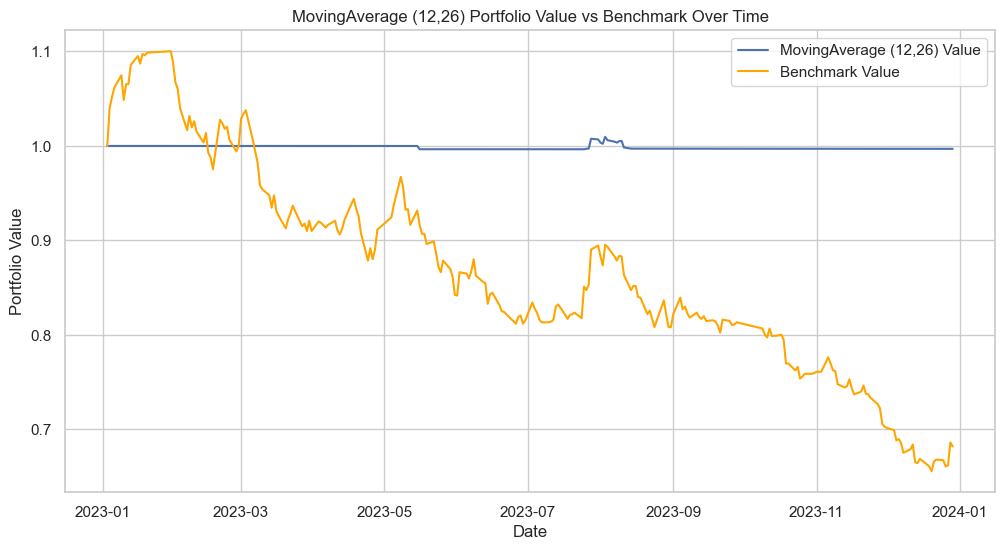

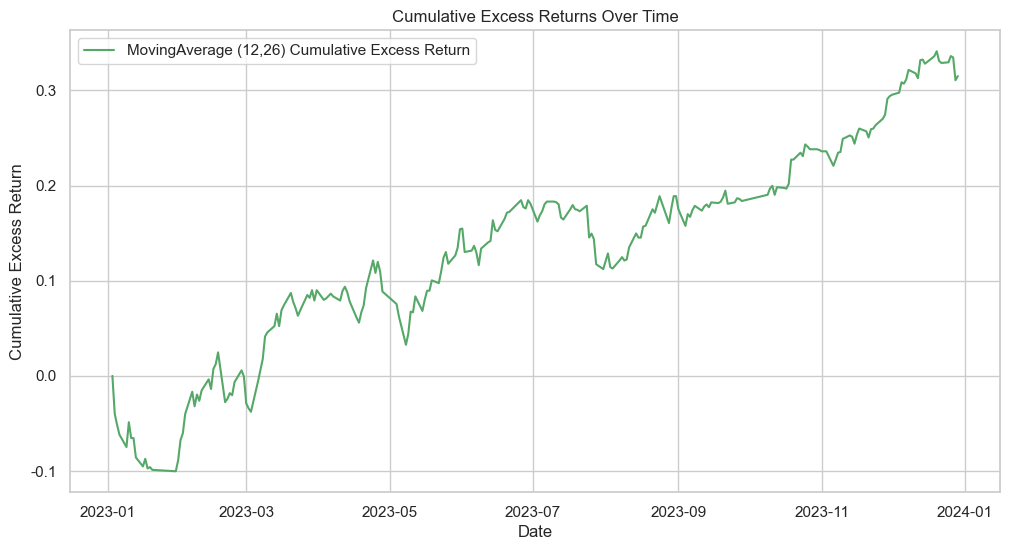

In [16]:
backtest.calculate_statistics()

# 检查一下策略

In [18]:
class MovingAverageStrategy_test:
    def __init__(self, short_window=12, long_window=26):
        self.short_window = short_window
        self.long_window = long_window
        self.name = f'MovingAverage ({self.short_window},{self.long_window})'
        
    def generate_signals(self, data):
        data = data.copy()
        data['ma_short'] = data['close'].rolling(window=self.short_window).mean()
        data['ma_long'] = data['close'].rolling(window=self.long_window).mean()

        # 生成买入信号：短期均线向上突破长期均线
        data['signal'] = 0
        data['signal'] = np.where((data['ma_short'] > data['ma_long']) & (data['ma_short'].shift(1) <= data['ma_long'].shift(1)), 1, data['signal'])

        # 生成卖出信号：价格跌破长期均线
        data['signal'] = np.where((data['close'] < data['ma_long']) & (data['close'].shift(1) >= data['ma_long'].shift(1)), -1, data['signal'])

        # 去除连续相同信号，只保留第一次出现的信号
        #data['signal'] = np.where(data['signal'] != data['signal'].shift(), data['signal'], 0)
        return data[['date', 'signal','close','ma_short','ma_long']]
        #return data

# 策略正常给出信号

In [20]:
data1=data.iloc[::-1].reset_index(drop=True)
strategy=MovingAverageStrategy_test(6,15)
strategy.generate_signals(data1).iloc[50:100]

,date,signal,close,ma_short,ma_long
50,2013-03-22,0,23.03,22.356667,22.585333
51,2013-03-25,0,22.76,22.450000,22.652667
52,2013-03-26,-1,22.14,22.581667,22.533333
53,2013-03-27,0,22.15,22.690000,22.393333
54,2013-03-28,0,20.02,22.176667,22.145333
55,2013-03-29,0,20.12,21.703333,21.962667
56,2013-04-01,0,20.39,21.263333,21.813333
57,2013-04-02,0,20.44,20.876667,21.728000
58,2013-04-03,0,20.45,20.595000,21.618667
59,2013-04-08,0,19.93,20.225000,21.502667
